In [20]:
# SAC (Soft Actor-Critic) 算法实现
# SAC是一种基于最大熵强化学习的off-policy算法，结合了策略梯度和Q学习的优点

import random
import gym
import numpy as np
from tqdm import tqdm
import torch
import torch.nn.functional as F
from torch.distributions import Normal
import matplotlib.pyplot as plt
import rl_utils

In [21]:
# ============ 连续动作空间的SAC实现 ============

class PolicyNetContinuous(torch.nn.Module):
    """连续动作空间的策略网络
    SAC中的策略网络输出动作分布的参数，并使用重参数化技巧
    """
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound):
        super(PolicyNetContinuous, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        # 输出动作均值
        self.fc_mu = torch.nn.Linear(hidden_dim, action_dim)
        # 输出动作标准差的对数值
        self.fc_std = torch.nn.Linear(hidden_dim, action_dim)
        self.action_bound = action_bound  # 动作边界

    def forward(self, x):
        x = F.relu(self.fc1(x))
        mu = self.fc_mu(x)
        std = F.softplus(self.fc_std(x))  # 确保标准差为正
        
        # 创建正态分布
        dist = Normal(mu, std)
        # 重参数化采样（rsample支持梯度回传）
        normal_sample = dist.rsample()
        # 计算对数概率
        log_prob = dist.log_prob(normal_sample)
        
        # 使用tanh将动作限制在[-1, 1]范围内
        action = torch.tanh(normal_sample)
        
        # 计算tanh变换后的对数概率密度
        # 这是SAC中的重要技巧，用于处理有界动作空间
        log_prob = log_prob - torch.log(1 - torch.tanh(action).pow(2) + 1e-7)
        
        # 缩放到实际动作范围
        action = action * self.action_bound
        return action, log_prob


class QValueNetContinuous(torch.nn.Module):
    """连续动作空间的Q网络
    SAC使用两个Q网络来减少过估计偏差
    """
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(QValueNetContinuous, self).__init__()
        # 输入是状态和动作的拼接
        self.fc1 = torch.nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc_out = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x, a):
        # 将状态和动作拼接作为输入
        cat = torch.cat([x, a], dim=1)
        x = F.relu(self.fc1(cat))
        x = F.relu(self.fc2(x))
        return self.fc_out(x)

In [22]:
class SACContinuous:
    """处理连续动作的SAC算法
    SAC的核心思想是最大化期望回报的同时最大化策略熵，提高探索能力
    """
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound,
                 actor_lr, critic_lr, alpha_lr, target_entropy, tau, gamma,
                 device):
        # 策略网络（Actor）
        self.actor = PolicyNetContinuous(state_dim, hidden_dim, action_dim,
                                         action_bound).to(device)
        
        # 两个Q网络（Critic），用于减少过估计
        self.critic_1 = QValueNetContinuous(state_dim, hidden_dim, action_dim).to(device)
        self.critic_2 = QValueNetContinuous(state_dim, hidden_dim, action_dim).to(device)
        
        # 两个目标Q网络，用于稳定训练
        self.target_critic_1 = QValueNetContinuous(state_dim, hidden_dim, action_dim).to(device)
        self.target_critic_2 = QValueNetContinuous(state_dim, hidden_dim, action_dim).to(device)
        
        # 初始化目标网络参数与主网络相同
        self.target_critic_1.load_state_dict(self.critic_1.state_dict())
        self.target_critic_2.load_state_dict(self.critic_2.state_dict())
        
        # 优化器
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_1_optimizer = torch.optim.Adam(self.critic_1.parameters(), lr=critic_lr)
        self.critic_2_optimizer = torch.optim.Adam(self.critic_2.parameters(), lr=critic_lr)
        
        # 温度参数α的对数值（自动调节熵权重）
        # 使用对数值可以确保α始终为正，并提高数值稳定性
        self.log_alpha = torch.tensor(np.log(0.01), dtype=torch.float)
        self.log_alpha.requires_grad = True  # 允许梯度更新
        self.log_alpha_optimizer = torch.optim.Adam([self.log_alpha], lr=alpha_lr)
        
        # SAC算法参数
        self.target_entropy = target_entropy  # 目标熵值
        self.gamma = gamma                    # 折扣因子
        self.tau = tau                       # 软更新参数
        self.device = device

    def take_action(self, state):
        """根据当前策略选择动作
        在SAC中，动作选择是随机的，有助于探索
        """
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        action = self.actor(state)[0]  # 只取动作，不要对数概率
        return [action.item()]

    def calc_target(self, rewards, next_states, dones):
        """计算目标Q值
        SAC的目标Q值包含熵正则化项
        """
        # 从策略网络采样下一状态的动作
        next_actions, log_prob = self.actor(next_states)
        entropy = -log_prob  # 熵 = -log_prob
        
        # 计算两个目标Q网络的Q值
        q1_value = self.target_critic_1(next_states, next_actions)
        q2_value = self.target_critic_2(next_states, next_actions)
        
        # 取较小的Q值（减少过估计）并加上熵项
        next_value = torch.min(q1_value, q2_value) + self.log_alpha.exp() * entropy
        
        # TD目标：r + γ * (Q(s',a') + α * H(π(·|s'))) * (1 - done)
        td_target = rewards + self.gamma * next_value * (1 - dones)
        return td_target

    def soft_update(self, net, target_net):
        """软更新目标网络
        θ_target = τ * θ + (1 - τ) * θ_target
        """
        for param_target, param in zip(target_net.parameters(), net.parameters()):
            param_target.data.copy_(param_target.data * (1.0 - self.tau) +
                                    param.data * self.tau)

    def update(self, transition_dict):
        """SAC算法的核心更新函数
        同时更新两个Q网络、策略网络和温度参数
        """
        # 准备训练数据
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions'], dtype=torch.float).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)
        
        # 奖励重塑，便于训练（针对倒立摆环境）
        rewards = (rewards + 8.0) / 8.0

        # ========== 更新两个Q网络 ==========
        td_target = self.calc_target(rewards, next_states, dones)
        
        # Q网络1的损失
        critic_1_loss = torch.mean(
            F.mse_loss(self.critic_1(states, actions), td_target.detach()))
        # Q网络2的损失
        critic_2_loss = torch.mean(
            F.mse_loss(self.critic_2(states, actions), td_target.detach()))
        
        # 更新Q网络1
        self.critic_1_optimizer.zero_grad()
        critic_1_loss.backward()
        self.critic_1_optimizer.step()
        
        # 更新Q网络2
        self.critic_2_optimizer.zero_grad()
        critic_2_loss.backward()
        self.critic_2_optimizer.step()

        # ========== 更新策略网络 ==========
        # 从当前策略采样动作
        new_actions, log_prob = self.actor(states)
        entropy = -log_prob
        
        # 计算两个Q网络的Q值
        q1_value = self.critic_1(states, new_actions)
        q2_value = self.critic_2(states, new_actions)
        
        # 策略损失：最大化 Q(s,a) + α * H(π(·|s))
        # 等价于最小化 -(Q(s,a) + α * H(π(·|s)))
        actor_loss = torch.mean(-self.log_alpha.exp() * entropy -
                                torch.min(q1_value, q2_value))
        
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ========== 更新温度参数α ==========
        # α的目标是使策略熵接近目标熵值
        alpha_loss = torch.mean(
            (entropy - self.target_entropy).detach() * self.log_alpha.exp())
        
        self.log_alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.log_alpha_optimizer.step()

        # ========== 软更新目标网络 ==========
        self.soft_update(self.critic_1, self.target_critic_1)
        self.soft_update(self.critic_2, self.target_critic_2)

In [23]:
# ============ 连续动作SAC训练示例 ============

# 环境设置
env_name = 'Pendulum-v1'
env = gym.make(env_name)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
action_bound = env.action_space.high[0]  # 动作最大值

# 设置随机种子
random.seed(0)
np.random.seed(0)
# env.seed(0)
torch.manual_seed(0)

# 超参数设置
actor_lr = 3e-4        # 策略网络学习率
critic_lr = 3e-3       # Q网络学习率
alpha_lr = 3e-4        # 温度参数学习率
num_episodes = 100     # 训练回合数
hidden_dim = 128       # 隐藏层维度
gamma = 0.99          # 折扣因子
tau = 0.005           # 软更新参数
buffer_size = 100000  # 经验回放缓冲区大小
minimal_size = 1000   # 开始训练前的最小样本数
batch_size = 64       # 批次大小
target_entropy = -env.action_space.shape[0]  # 目标熵（负的动作维度）

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# 创建经验回放缓冲区和SAC智能体
replay_buffer = rl_utils.ReplayBuffer(buffer_size)
agent = SACContinuous(state_dim, hidden_dim, action_dim, action_bound,
                      actor_lr, critic_lr, alpha_lr, target_entropy, tau,
                      gamma, device)

# 开始训练
return_list = rl_utils.train_off_policy_agent(env, agent, num_episodes,
                                              replay_buffer, minimal_size,
                                              batch_size)

# 训练过程输出示例：
# Iteration 0: 100%|██████████| 10/10 [00:07<00:00,  1.35it/s, episode=10, return=-1534.655]
# Iteration 1: 100%|██████████| 10/10 [00:13<00:00,  1.32s/it, episode=20, return=-1085.715]
# ... (训练过程中回合奖励逐渐提高)

Iteration 9: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s, episode=100, return=-237.961]


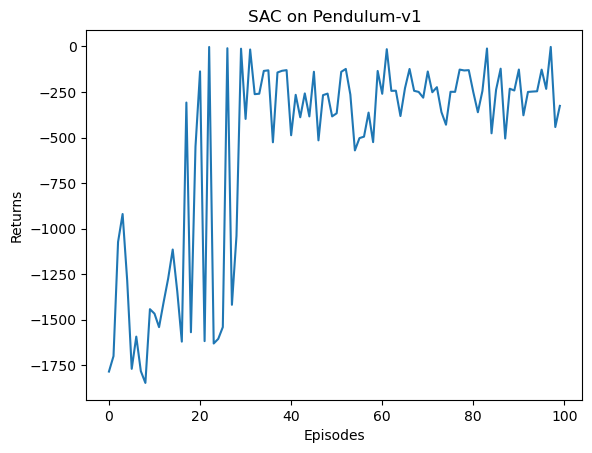

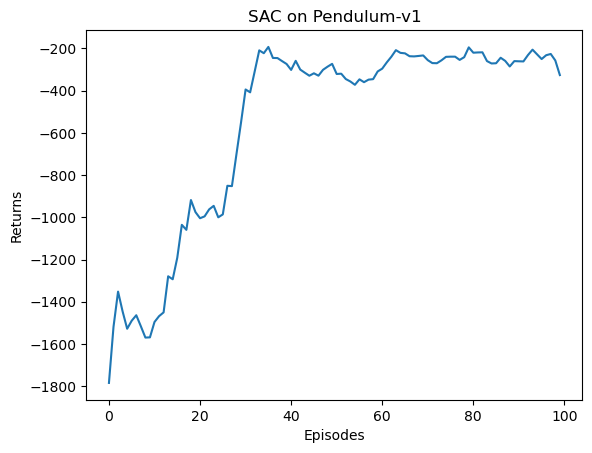

In [24]:
# ============ 连续动作SAC结果可视化 ============

# 绘制训练结果
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('SAC on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('SAC on {}'.format(env_name))
plt.show()

In [25]:
# ============ 离散动作空间的SAC实现 ============

class PolicyNet(torch.nn.Module):
    """离散动作空间的策略网络
    直接输出每个动作的概率
    """
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=1)


class QValueNet(torch.nn.Module):
    """离散动作空间的Q网络
    输出每个动作的Q值
    """
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(QValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [26]:
class SAC:
    """处理离散动作的SAC算法
    与连续版本的主要区别在于动作采样和Q值计算方式
    """
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                 alpha_lr, target_entropy, tau, gamma, device):
        # 网络初始化
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.critic_1 = QValueNet(state_dim, hidden_dim, action_dim).to(device)
        self.critic_2 = QValueNet(state_dim, hidden_dim, action_dim).to(device)
        self.target_critic_1 = QValueNet(state_dim, hidden_dim, action_dim).to(device)
        self.target_critic_2 = QValueNet(state_dim, hidden_dim, action_dim).to(device)
        
        # 初始化目标网络
        self.target_critic_1.load_state_dict(self.critic_1.state_dict())
        self.target_critic_2.load_state_dict(self.critic_2.state_dict())
        
        # 优化器
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_1_optimizer = torch.optim.Adam(self.critic_1.parameters(), lr=critic_lr)
        self.critic_2_optimizer = torch.optim.Adam(self.critic_2.parameters(), lr=critic_lr)
        
        # 温度参数
        self.log_alpha = torch.tensor(np.log(0.01), dtype=torch.float)
        self.log_alpha.requires_grad = True
        self.log_alpha_optimizer = torch.optim.Adam([self.log_alpha], lr=alpha_lr)
        
        self.target_entropy = target_entropy
        self.gamma = gamma
        self.tau = tau
        self.device = device

    def take_action(self, state):
        """离散动作选择
        根据策略概率分布采样动作
        """
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        probs = self.actor(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()

    def calc_target(self, rewards, next_states, dones):
        """计算离散动作的目标Q值
        使用策略网络的输出概率进行期望计算
        """
        next_probs = self.actor(next_states)
        next_log_probs = torch.log(next_probs + 1e-8)
        # 计算策略熵
        entropy = -torch.sum(next_probs * next_log_probs, dim=1, keepdim=True)
        
        # 获取所有动作的Q值
        q1_value = self.target_critic_1(next_states)
        q2_value = self.target_critic_2(next_states)
        
        # 计算期望Q值（概率加权）
        min_qvalue = torch.sum(next_probs * torch.min(q1_value, q2_value),
                               dim=1, keepdim=True)
        
        # 加上熵项
        next_value = min_qvalue + self.log_alpha.exp() * entropy
        td_target = rewards + self.gamma * next_value * (1 - dones)
        return td_target

    def soft_update(self, net, target_net):
        """软更新目标网络"""
        for param_target, param in zip(target_net.parameters(), net.parameters()):
            param_target.data.copy_(param_target.data * (1.0 - self.tau) +
                                    param.data * self.tau)

    def update(self, transition_dict):
        """离散动作SAC更新"""
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)

        # 更新Q网络
        td_target = self.calc_target(rewards, next_states, dones)
        critic_1_q_values = self.critic_1(states).gather(1, actions)
        critic_2_q_values = self.critic_2(states).gather(1, actions)
        
        critic_1_loss = torch.mean(F.mse_loss(critic_1_q_values, td_target.detach()))
        critic_2_loss = torch.mean(F.mse_loss(critic_2_q_values, td_target.detach()))
        
        self.critic_1_optimizer.zero_grad()
        critic_1_loss.backward()
        self.critic_1_optimizer.step()
        
        self.critic_2_optimizer.zero_grad()
        critic_2_loss.backward()
        self.critic_2_optimizer.step()

        # 更新策略网络
        probs = self.actor(states)
        log_probs = torch.log(probs + 1e-8)
        entropy = -torch.sum(probs * log_probs, dim=1, keepdim=True)
        
        q1_value = self.critic_1(states)
        q2_value = self.critic_2(states)
        min_qvalue = torch.sum(probs * torch.min(q1_value, q2_value),
                               dim=1, keepdim=True)
        
        actor_loss = torch.mean(-self.log_alpha.exp() * entropy - min_qvalue)
        
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # 更新温度参数
        alpha_loss = torch.mean(
            (entropy - self.target_entropy).detach() * self.log_alpha.exp())
        
        self.log_alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.log_alpha_optimizer.step()

        # 软更新目标网络
        self.soft_update(self.critic_1, self.target_critic_1)
        self.soft_update(self.critic_2, self.target_critic_2)

In [27]:
# ============ 离散动作SAC训练示例 ============

# 超参数设置
actor_lr = 1e-3
critic_lr = 1e-2
alpha_lr = 1e-2
num_episodes = 200
hidden_dim = 128
gamma = 0.98
tau = 0.005
buffer_size = 10000
minimal_size = 500
batch_size = 64
target_entropy = -1  # 离散动作的目标熵

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# CartPole环境（离散动作）
env_name = 'CartPole-v0'
env = gym.make(env_name)
random.seed(0)
np.random.seed(0)
# env.seed(0)
torch.manual_seed(0)

replay_buffer = rl_utils.ReplayBuffer(buffer_size)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

# 创建离散动作SAC智能体
agent = SAC(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, alpha_lr,
            target_entropy, tau, gamma, device)

# 训练
return_list = rl_utils.train_off_policy_agent(env, agent, num_episodes,
                                              replay_buffer, minimal_size,
                                              batch_size)

# 训练过程输出示例：
# Iteration 0: 100%|██████████| 20/20 [00:00<00:00, 193.82it/s, episode=20, return=19.700]
# Iteration 1: 100%|██████████| 20/20 [00:00<00:00, 29.39it/s, episode=40, return=10.600]
# ... (训练过程中回合奖励逐渐提高)

Iteration 9: 100%|██████████| 20/20 [00:10<00:00,  1.99it/s, episode=200, return=182.500]


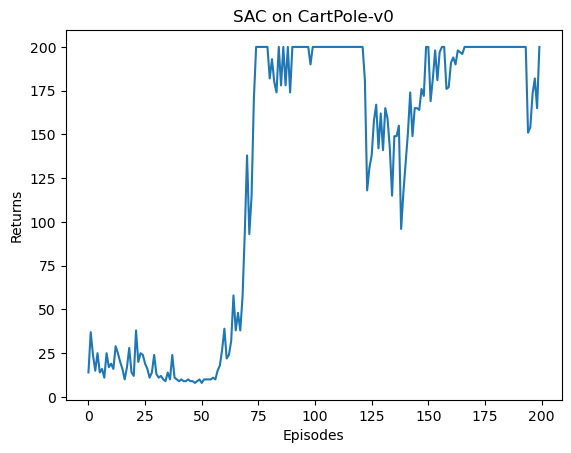

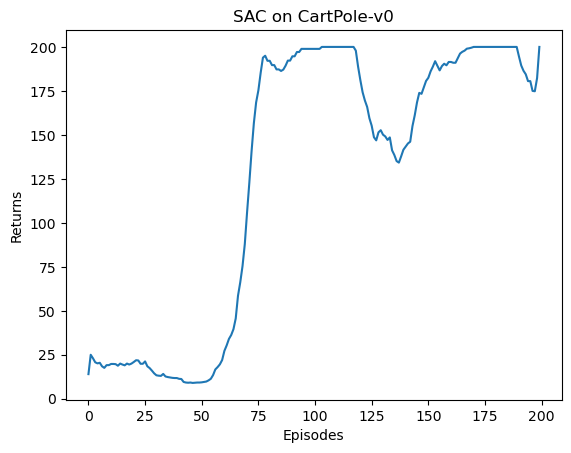

In [28]:
# ============ 离散动作SAC结果可视化 ============

# 结果可视化
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('SAC on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('SAC on {}'.format(env_name))
plt.show()

## SAC算法总结

SAC算法的核心特点：

### 1. 最大熵强化学习
- 目标函数包含熵正则化项，鼓励探索
- 自动调节温度参数α来平衡探索与利用

### 2. Off-policy学习
- 使用经验回放缓冲区，提高样本效率
- 可以重复使用历史经验数据

### 3. 双Q网络
- 使用两个Q网络减少过估计偏差
- 取较小的Q值作为目标值计算

### 4. 软更新
- 目标网络参数缓慢更新，提高训练稳定性

### 5. 重参数化技巧
- 连续动作空间中使用重参数化采样
- 支持梯度回传，实现端到端训练

SAC适用于连续和离散动作空间，在样本效率和性能方面都有很好的表现。